Mean Absolute Error (MAE): 64.91652777777777
Root Mean Squared Error (RMSE): 84.21716230311307


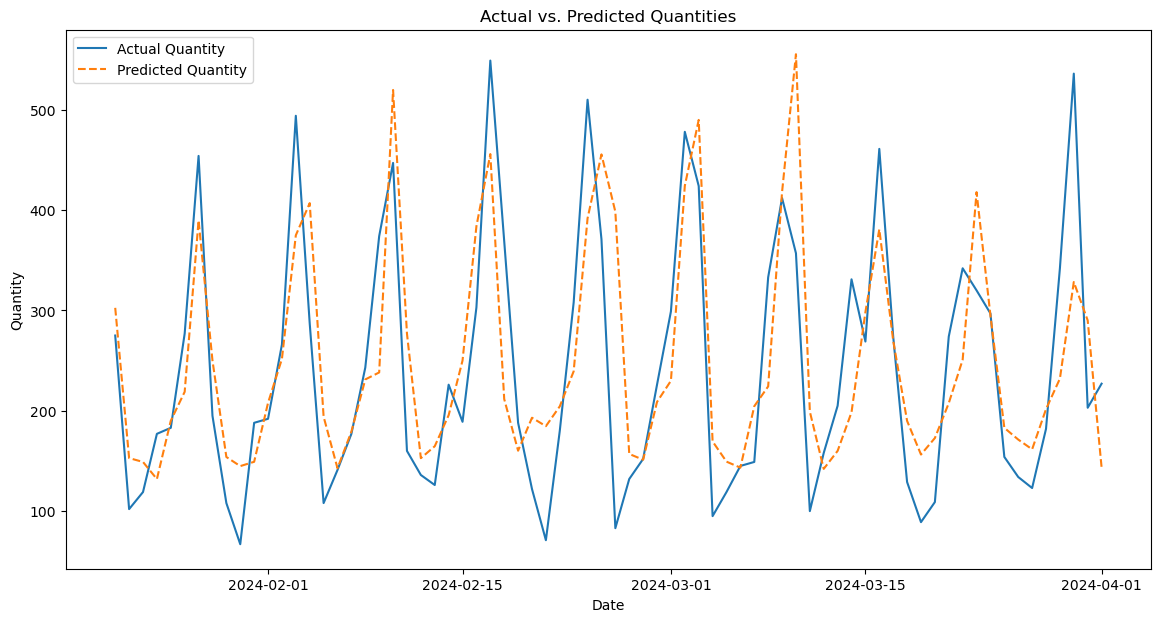

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

file_path = 'sales-output-new-5.csv'
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data[' Date'].str.strip(), format='mixed')

daily_data = data.groupby(data['Date'].dt.date)['Quantity'].sum().reset_index()

daily_data['Date'] = pd.to_datetime(daily_data['Date'])

lags = 7
for lag in range(1, lags + 1):
    daily_data[f'lag_{lag}'] = daily_data['Quantity'].shift(lag)

daily_data = daily_data.dropna()

split_index = int(len(daily_data) * 0.8)

train = daily_data[:split_index]
test = daily_data[split_index:]

X_train = train.drop(['Date', 'Quantity'], axis=1)
y_train = train['Quantity']
X_test = test.drop(['Date', 'Quantity'], axis=1)
y_test = test['Quantity']

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

plt.figure(figsize=(14, 7))
plt.plot(test['Date'], y_test, label='Actual Quantity')
plt.plot(test['Date'], y_pred, label='Predicted Quantity', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Quantities')
plt.legend()
plt.show()

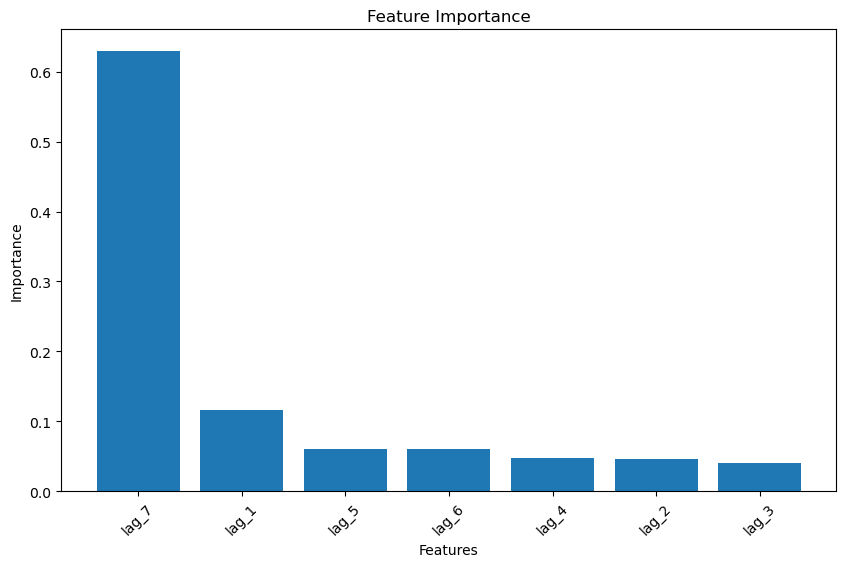

,Feature,Importance
6,lag_7,0.628896
0,lag_1,0.116160
4,lag_5,0.060945
5,lag_6,0.059873
3,lag_4,0.047863
1,lag_2,0.046216
2,lag_3,0.040048


In [3]:
feature_importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()


importance_df

                            MAE          RMSE
Linear Regression  7.465848e-13  8.846318e-13
Random Forest      5.272454e+01  6.692607e+01
Gradient Boosting  5.432673e+01  6.998639e+01
XGBoost            5.516872e+01  7.332210e+01


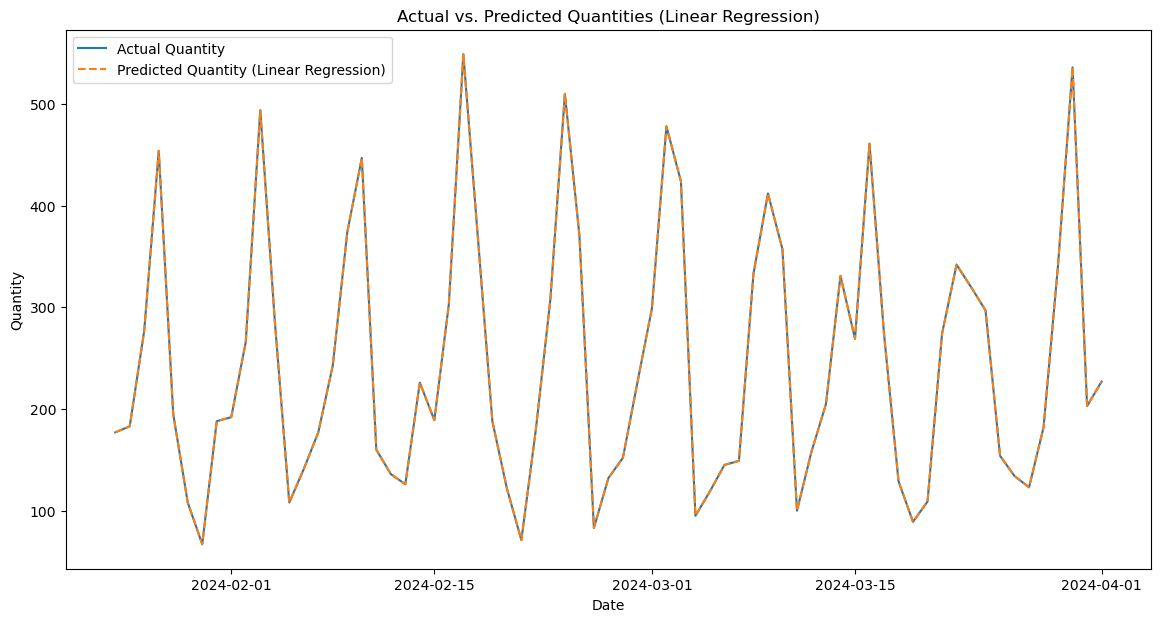

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt



for lag in range(1, 15):
    daily_data[f'lag_{lag}'] = daily_data['Quantity'].shift(lag)

daily_data['rolling_mean_7'] = daily_data['Quantity'].rolling(window=7).mean()
daily_data['rolling_std_7'] = daily_data['Quantity'].rolling(window=7).std()

daily_data = daily_data.dropna()

split_index = int(len(daily_data) * 0.8)
train = daily_data[:split_index]
test = daily_data[split_index:]

X_train = train.drop(['Date', 'Quantity'], axis=1)
y_train = train['Quantity']
X_test = test.drop(['Date', 'Quantity'], axis=1)
y_test = test['Quantity']

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}

results_df = pd.DataFrame(results).T

print(results_df)

best_model_name = results_df['RMSE'].idxmin()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(test['Date'], y_test, label='Actual Quantity')
plt.plot(test['Date'], y_pred_best, label=f'Predicted Quantity ({best_model_name})', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title(f'Actual vs. Predicted Quantities ({best_model_name})')
plt.legend()
plt.show()


/var/folders/40/6z6fw5_s1977zvkchq47yn280000gn/T/ipykernel_2222/3493320851.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Predicted_{model_name}'] = y_pred
/var/folders/40/6z6fw5_s1977zvkchq47yn280000gn/T/ipykernel_2222/3493320851.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Predicted_{model_name}'] = y_pred
/var/folders/40/6z6fw5_s1977zvkchq47yn280000gn/T/ipykernel_2222/3493320851.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


                            MAE          RMSE
Linear Regression  4.528095e-13  5.678498e-13
Random Forest      5.633717e+01  7.050322e+01
Gradient Boosting  5.528312e+01  6.873865e+01
XGBoost            6.163198e+01  7.995398e+01


/var/folders/40/6z6fw5_s1977zvkchq47yn280000gn/T/ipykernel_2222/3493320851.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Predicted_{model_name}'] = y_pred


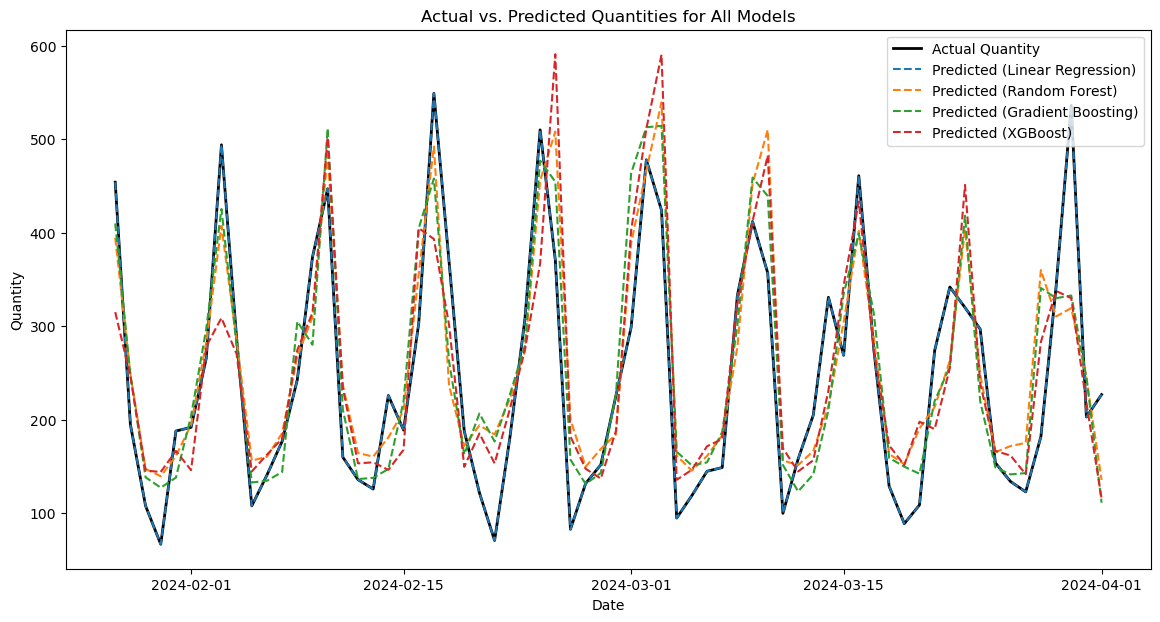

In [5]:
for lag in range(1, 15):
    daily_data[f'lag_{lag}'] = daily_data['Quantity'].shift(lag)

daily_data['rolling_mean_7'] = daily_data['Quantity'].rolling(window=7).mean()
daily_data['rolling_std_7'] = daily_data['Quantity'].rolling(window=7).std()

daily_data = daily_data.dropna()

split_index = int(len(daily_data) * 0.8)
train = daily_data[:split_index]
test = daily_data[split_index:]

X_train = train.drop(['Date', 'Quantity'], axis=1)
y_train = train['Quantity']
X_test = test.drop(['Date', 'Quantity'], axis=1)
y_test = test['Quantity']

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}
    test[f'Predicted_{model_name}'] = y_pred

results_df = pd.DataFrame(results).T

print(results_df)

plt.figure(figsize=(14, 7))
plt.plot(test['Date'], y_test, label='Actual Quantity', color='black', linewidth=2)
for model_name in models.keys():
    plt.plot(test['Date'], test[f'Predicted_{model_name}'], label=f'Predicted ({model_name})', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Quantities for All Models')
plt.legend()
plt.show()